In [2]:
from __future__ import annotations
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 200)

In [3]:
INFILES = [
    '/home/grace/work/SEER/data/survival/raw/pancancer_lungmetTrue_2010_2014.txt',
    '/home/grace/work/SEER/data/survival/raw/pancancer_lungmetTrue_2015_2019.txt',
    '/home/grace/work/SEER/data/survival/raw/lungPrimaries_2010_2014.txt',
    '/home/grace/work/SEER/data/survival/raw/lungPrimaries_2015_2019.txt',
]
LABELS = [
    'metastasis 2010-2014',
    'metastasis 2015-2019',
    'primary 2010-2014',
    'primary 2015-2019',
]

def clean_survival_matrix(inpath: str) -> str:
    outpath = inpath.replace('.txt', '.clean.tsv')
    outpath = outpath.replace('/raw/', '/clean/')
    with open(inpath, 'r') as infp:
        with open(outpath, 'w') as outfp:
            for line in infp.readlines():
                if 'Age-Standardized Life' in line:
                    lsplit = line.split('\t')
                    outfp.write('\t'.join(lsplit[2:]))
    return outpath 

def fmt_month(text: str) -> int:
    return int(text.split('<')[-1].replace('mo', '').strip())

def fmt_percentages(text: str) -> float:
    return float(text.strip('%'))

tables = []
for infile, label in zip(INFILES, LABELS):
    cleanfile = clean_survival_matrix(infile)
    
    # load to dataframe
    table = pd.read_csv(cleanfile, header=None, sep='\t', na_values='.')
    table.columns = [
        'month', 
        'alive_at_start', 'died', 
        'lost_to_followup', 
        'observed_int', 'observed_cum', 
        'expected_int', 'expected_cum', 
        'relative_int', 'relative_cum',
        'SE_observed_int', 'SE_observed_cum',
        'SE_relative_int', 'SE_relative_cum'
    ]
    table['month'] = table['month'].apply(fmt_month)
    table = table[table['observed_cum']!='+']
    table['observed_cum'] = table['observed_cum'].apply(fmt_percentages)
    table['SE_observed_cum'] = table['SE_observed_cum'].apply(fmt_percentages)
    tables.append(table)

    

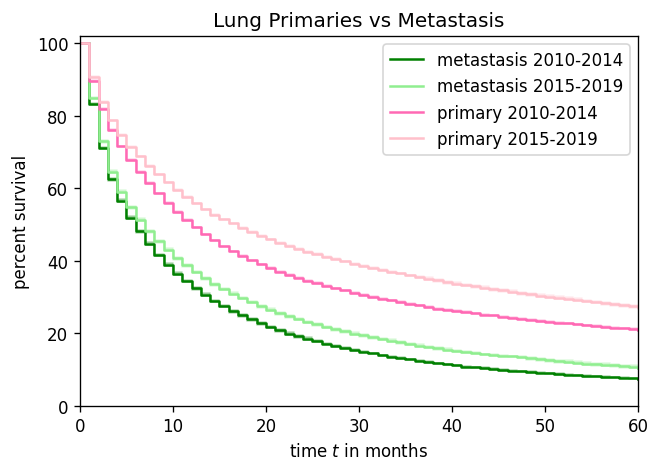

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_survival(tables: list[pd.DataFrame], labels: list[str]) -> None:
    plt.figure(figsize=(6, 4), dpi=120)
    
    colors = ['green', 'lightgreen', 'hotpink', 'pink']
    for color, label, table in zip(colors, labels, tables):
        temp = pd.DataFrame(index=table.index)
        temp['time'] = table['month']
        temp['survival'] = table['observed_cum']
        temp['ci_low'] = table['observed_cum'] - 1.96*table['SE_' + 'observed_cum']
        temp['ci_high'] = table['observed_cum'] + 1.96*table['SE_' + 'observed_cum']
        temp.loc[temp.shape[0]] = {'time': 0, 'survival': 100, 'ci_low': 100, 'ci_high': 100}
        temp = temp.sort_values('time')
        plt.step(temp['time'], temp['survival'], where="post", label=label, color=color)
        plt.fill_between(temp['time'], temp['ci_low'], temp['ci_high'], alpha=0.25, step="post", color=color)
    
    plt.ylabel(r"percent survival")
    plt.xlabel("time $t$ in months")
    plt.legend()
    # plt.title('All Cancers, Brain Met == True')
    plt.title('Lung Primaries vs Metastasis')
    plt.ylim((0, 102))
    plt.xlim((0, 60))
    filepath = '/home/grace/work/SEER/outputs/survival/lung_primaries_metastasis.png'
    plt.savefig(filepath)

plot_survival(tables, LABELS)